In [6]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from aurora import Aurora

from bfm_finetune.aurora_mod import AuroraFlex
# from bfm_finetune.plots import plot_eval
from bfm_finetune.plots_v2 import plot_eval
from bfm_finetune.dataloaders.geolifeclef_species.dataloader import GeoLifeCLEFSpeciesDataset
from bfm_finetune.dataloaders.dataloader_utils import custom_collate_fn
from bfm_finetune.utils import load_checkpoint, seed_everything, load_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed_everything(42)

In [7]:
base_model = Aurora(use_lora=False) # stabilise_level_agg=True
base_model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt") # strict=False
atmos_levels = (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
base_model.to(device)

num_species = 500

In [25]:
# PATH = "/home/thanasis.trantas/github_projects/bfm-finetune/bfm_finetune/outputs/2025-04-03/13-11-19-0.04.loss/checkpoints"
PATH = ".."
PATH = "../outputs/2025-04-17/10-26-46"
CHECKPOINT_PATH = Path(PATH) / "checkpoints"
cfg = load_config(PATH)

In [26]:
val_dataset = GeoLifeCLEFSpeciesDataset(num_species=num_species, mode="val", negative_lon_mode=cfg.dataset.negative_lon_mode)
val_dataloader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=1,
    )

lat_lon = val_dataset.get_lat_lon()

files 1


In [27]:
model = AuroraFlex(base_model=base_model, in_channels=num_species, hidden_channels=160,
                    out_channels=num_species, atmos_levels=atmos_levels, lat_lon=lat_lon,
                    supersampling_cfg=cfg.model.supersampling)
model.to(device)

params_to_optimize = model.parameters()
optimizer = torch.optim.AdamW(params_to_optimize, lr=1.0)

Initialized AuroraFlex Mod


In [28]:
_, _ = load_checkpoint(model, optimizer, CHECKPOINT_PATH)

Loaded checkpoint from ../outputs/2025-04-17/10-26-46/checkpoints/best_checkpoint.pth (epoch 41, loss: 5.5672)


In [29]:
def roll_tensor_to_match_lon(tensor: torch.Tensor, lon: torch.Tensor) -> torch.Tensor:
    """
    Rolls a tensor along its longitude axis to align with 0–360 longitude grid.
    
    Args:
        tensor: torch.Tensor with longitude on the last axis.
        lon: torch.Tensor with longitude values.
    
    Returns:
        torch.Tensor with values rolled to match 0 at start.
    """
    if not isinstance(lon, torch.Tensor):
        lon = torch.tensor(lon)

    # Convert longitudes to 0–360 if needed
    lon = torch.where(lon < 0, lon + 360, lon)

    # Find shift to align 0° longitude at start
    shift = torch.argmin(lon).item()  # Get the int value

    # Only roll if necessary
    if shift != 0:
        lon_axis = tensor.dim() - 1
        tensor = torch.roll(tensor, shifts=-shift, dims=lon_axis)

    return tensor

0.0 359.75


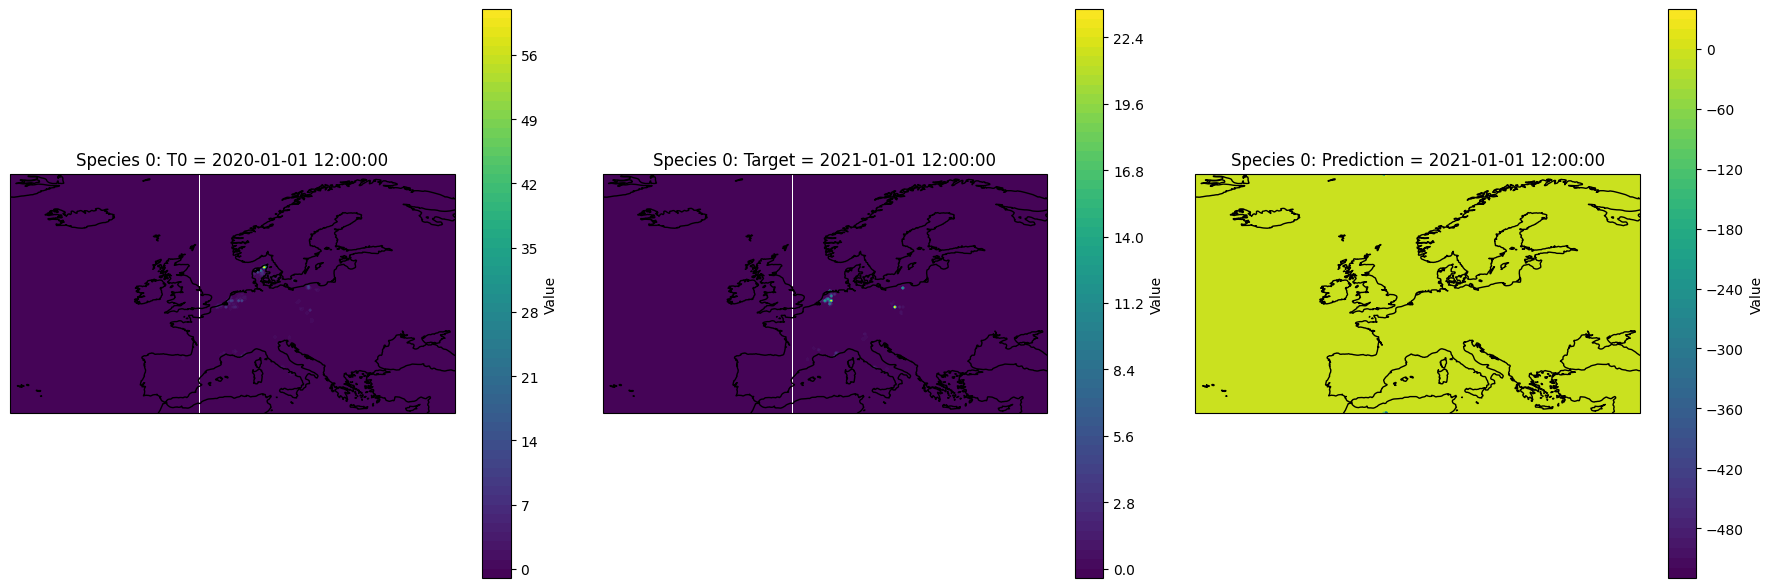

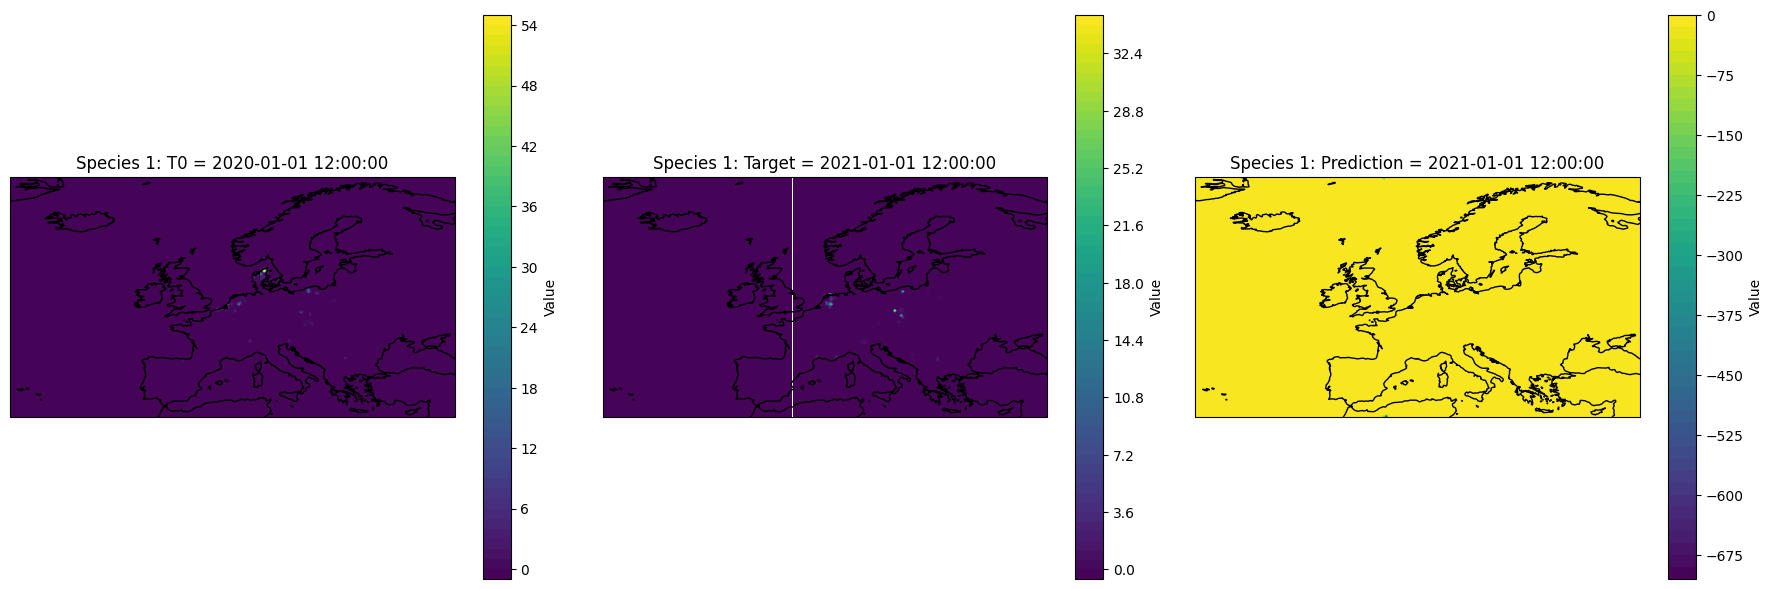

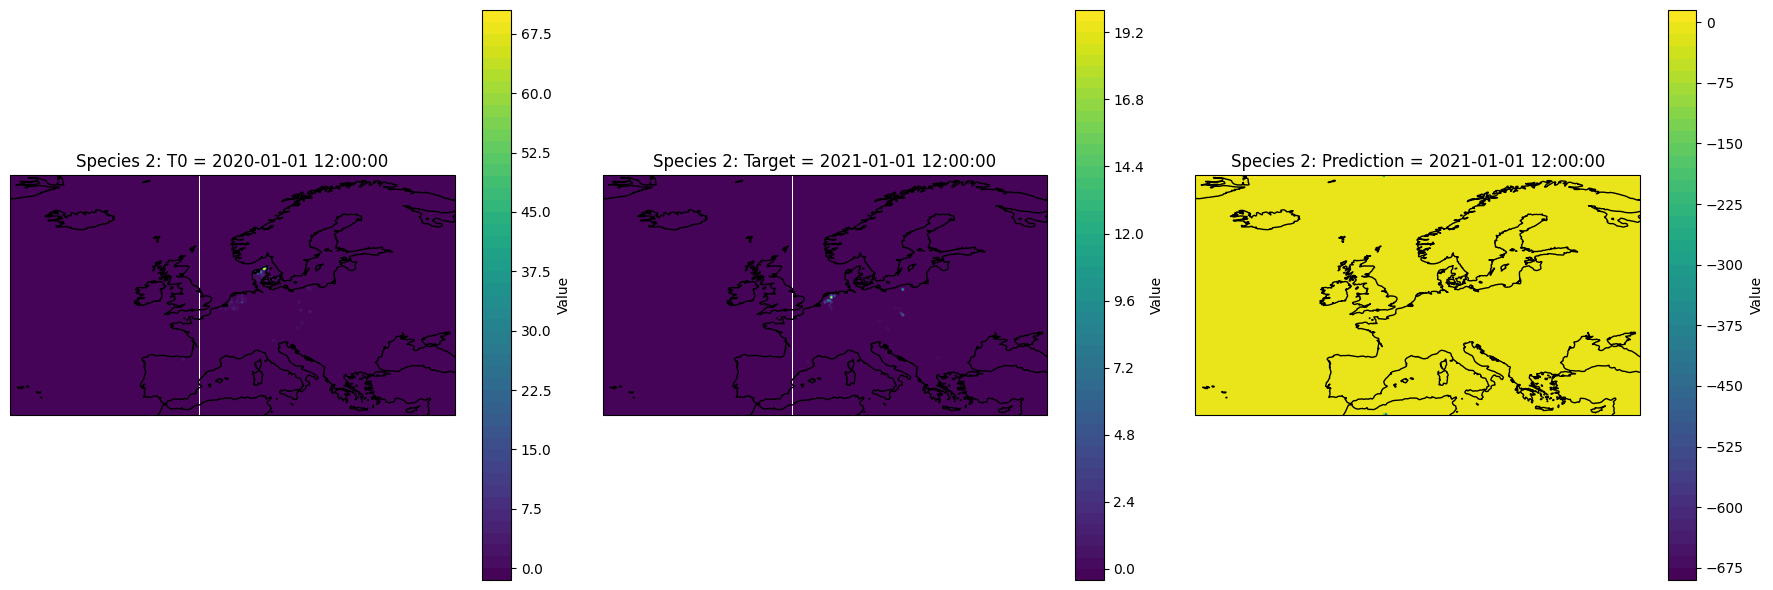

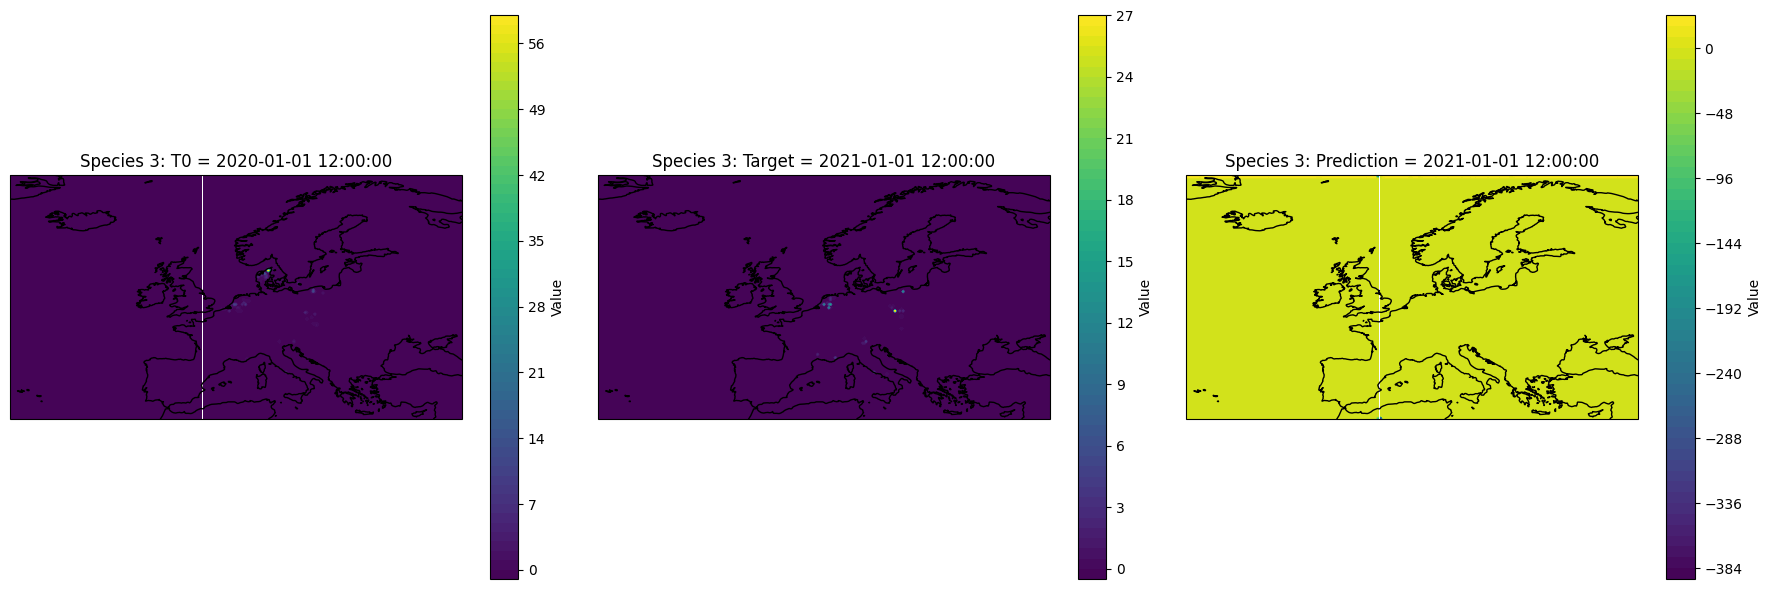

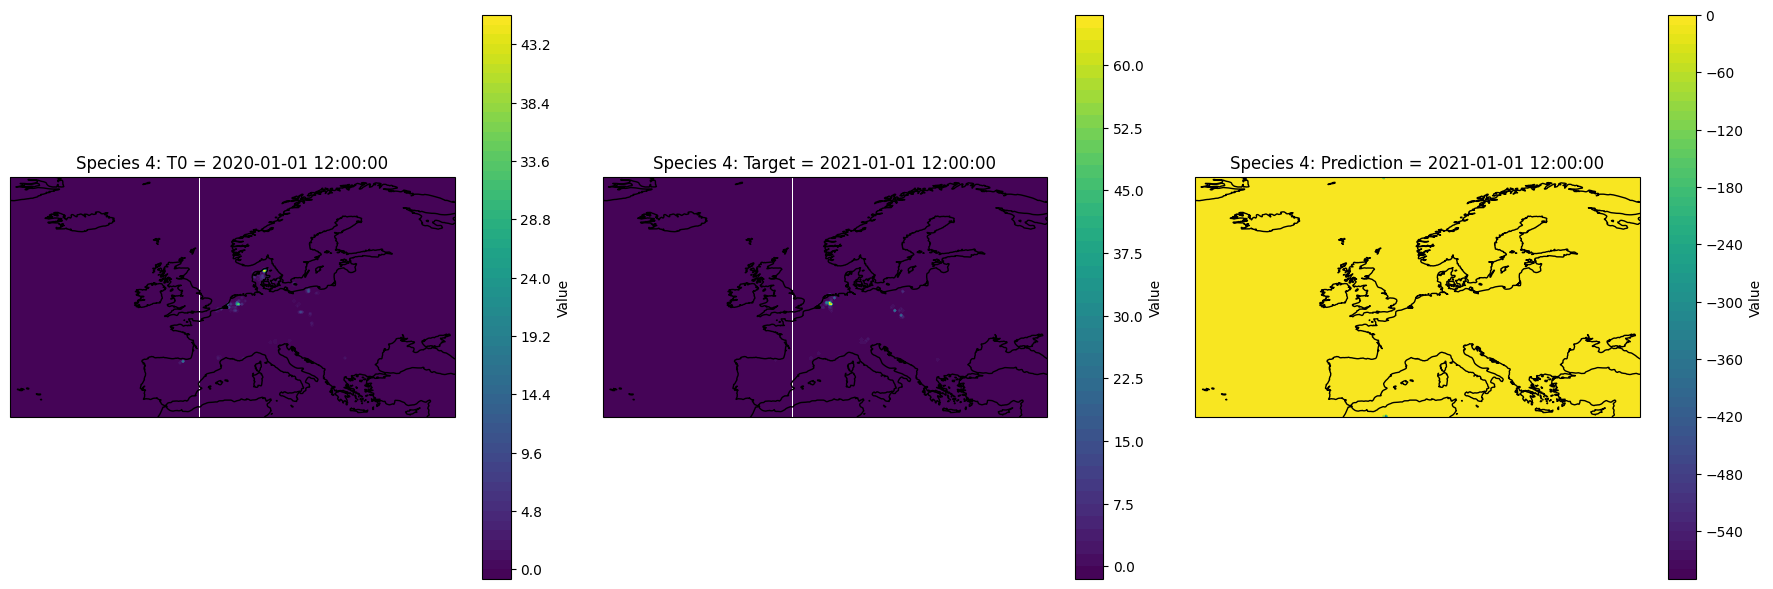

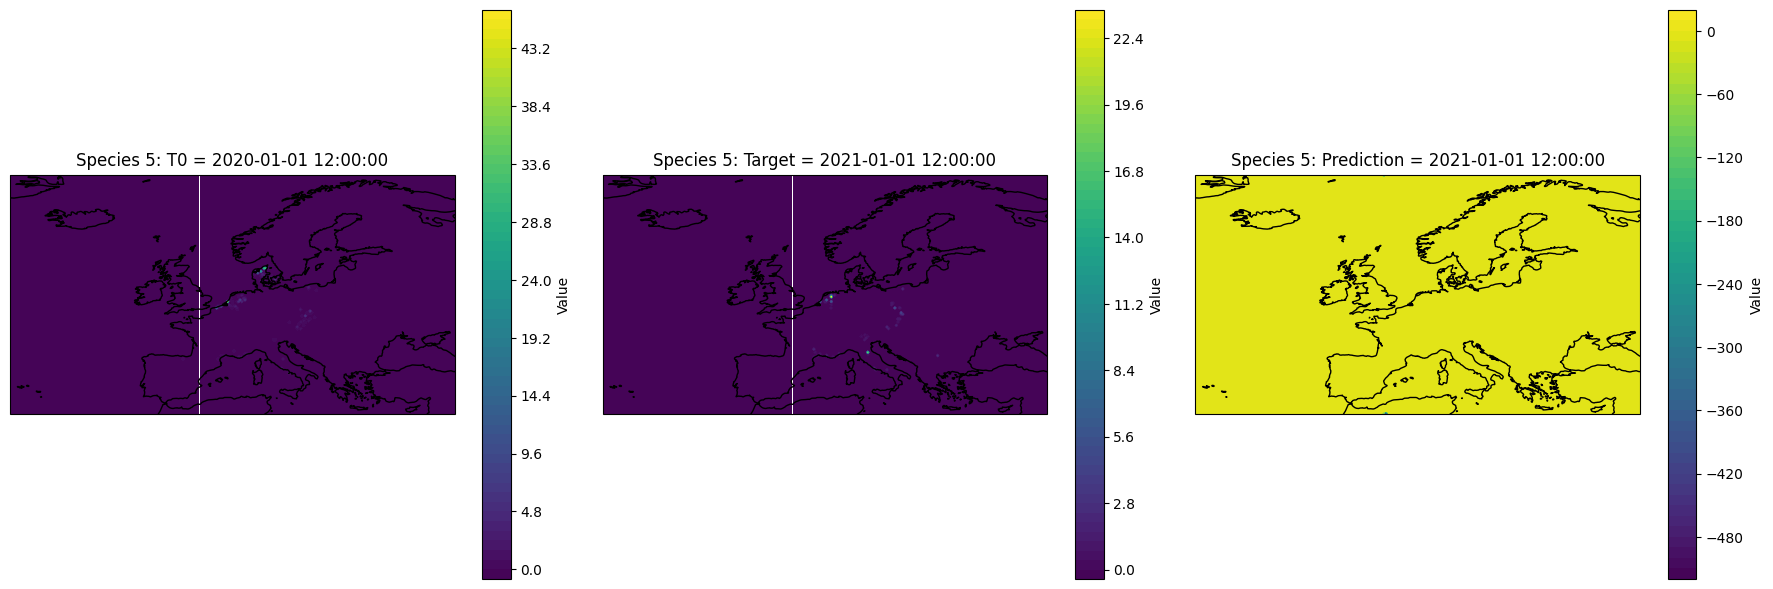

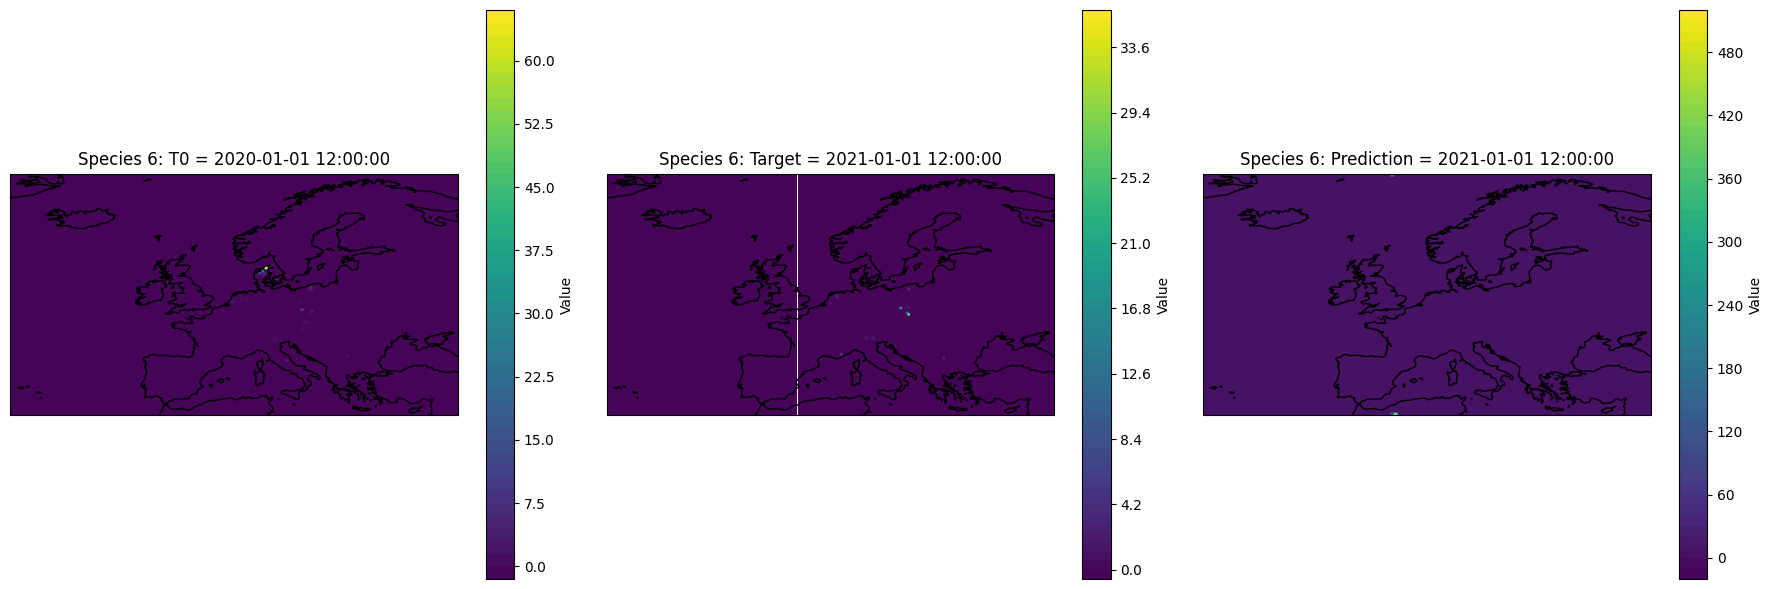

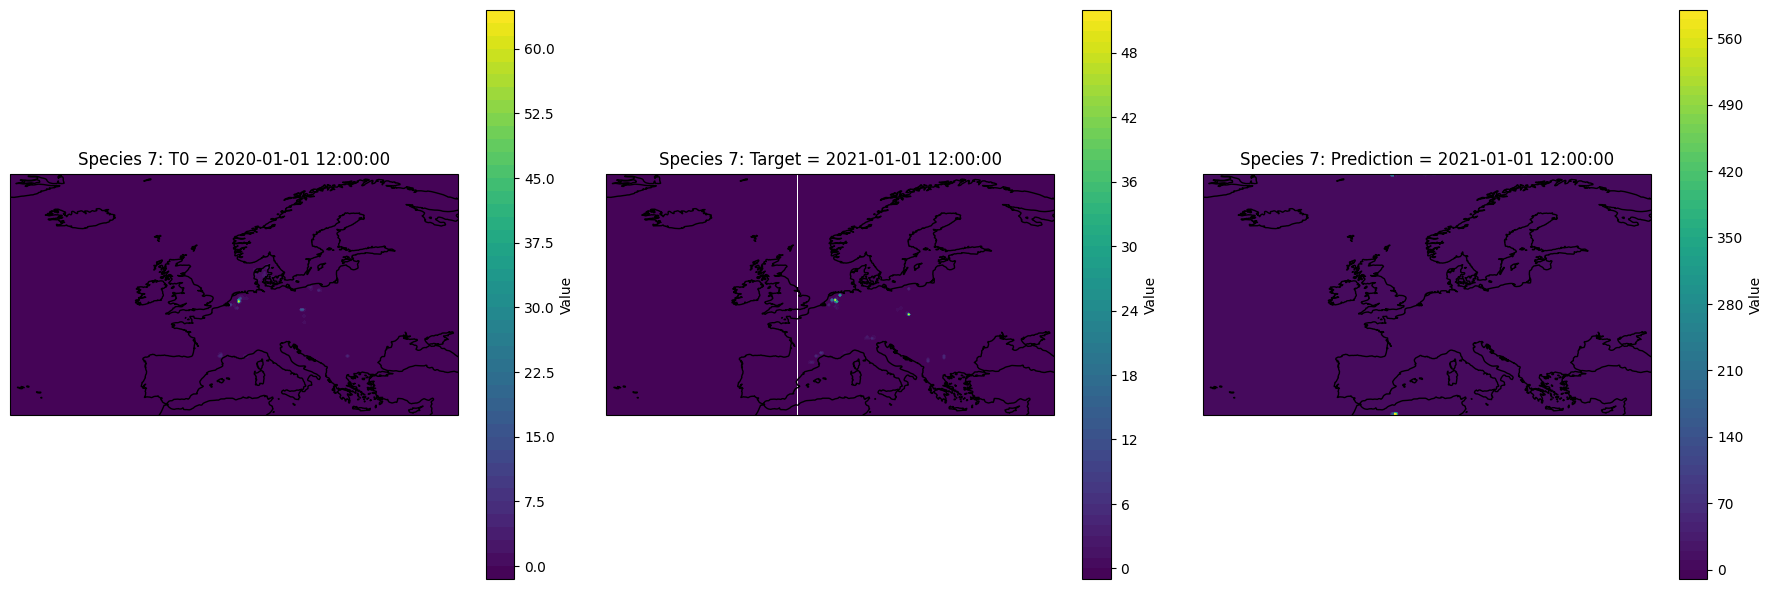

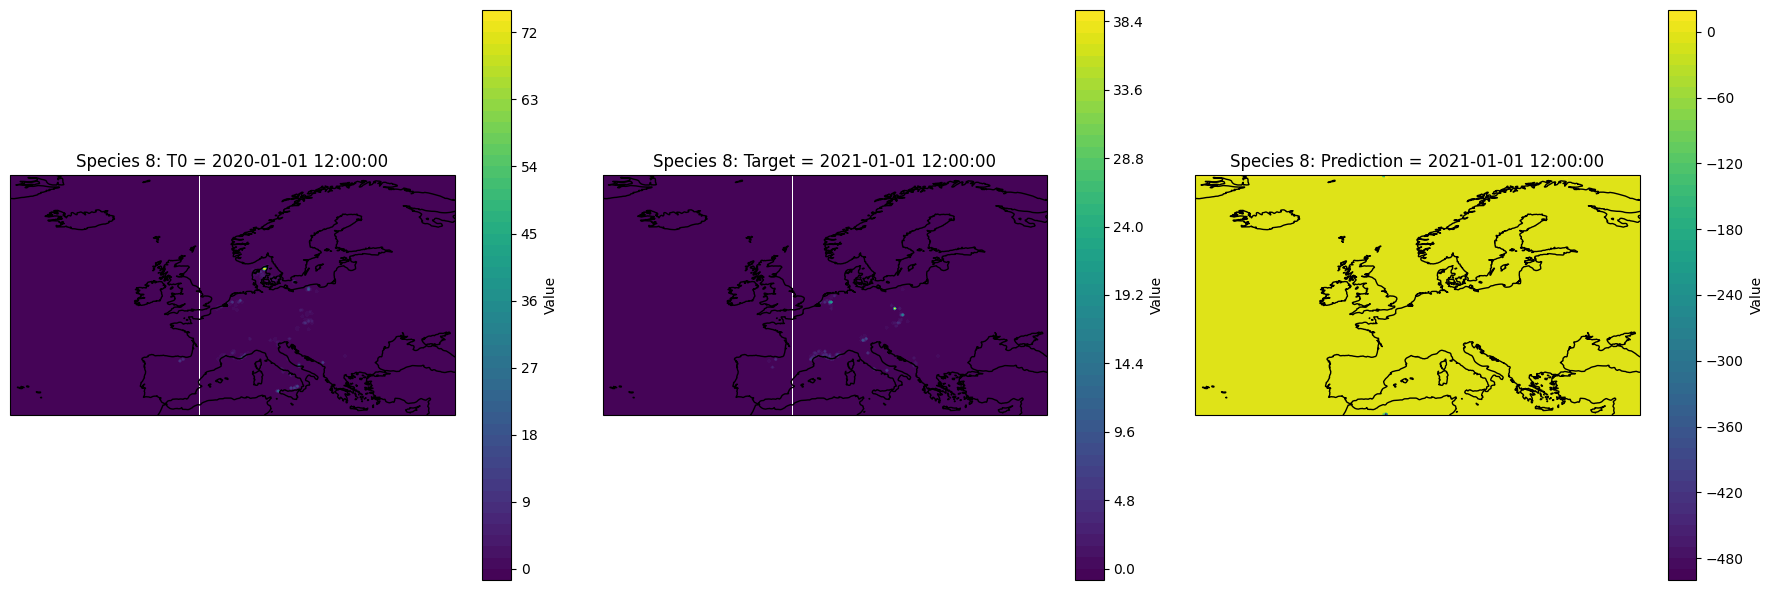

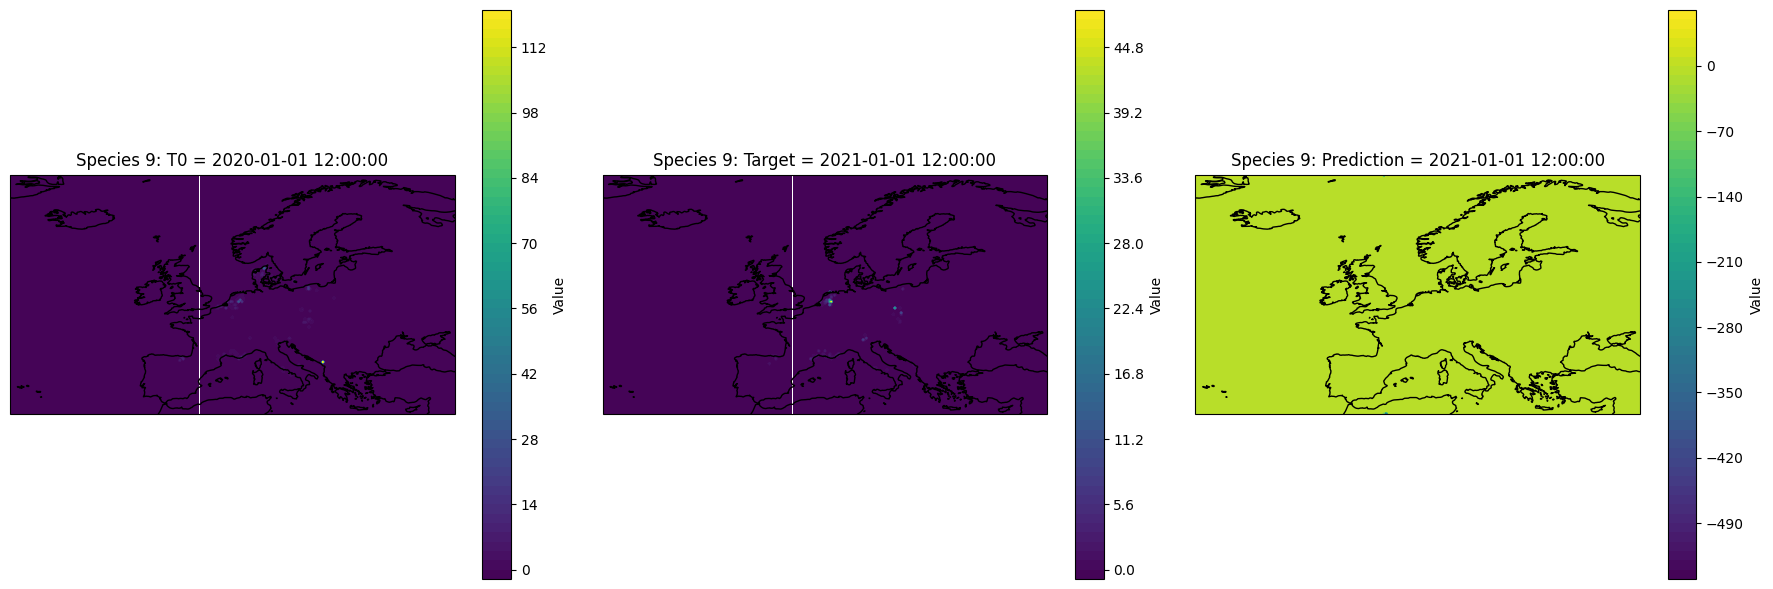

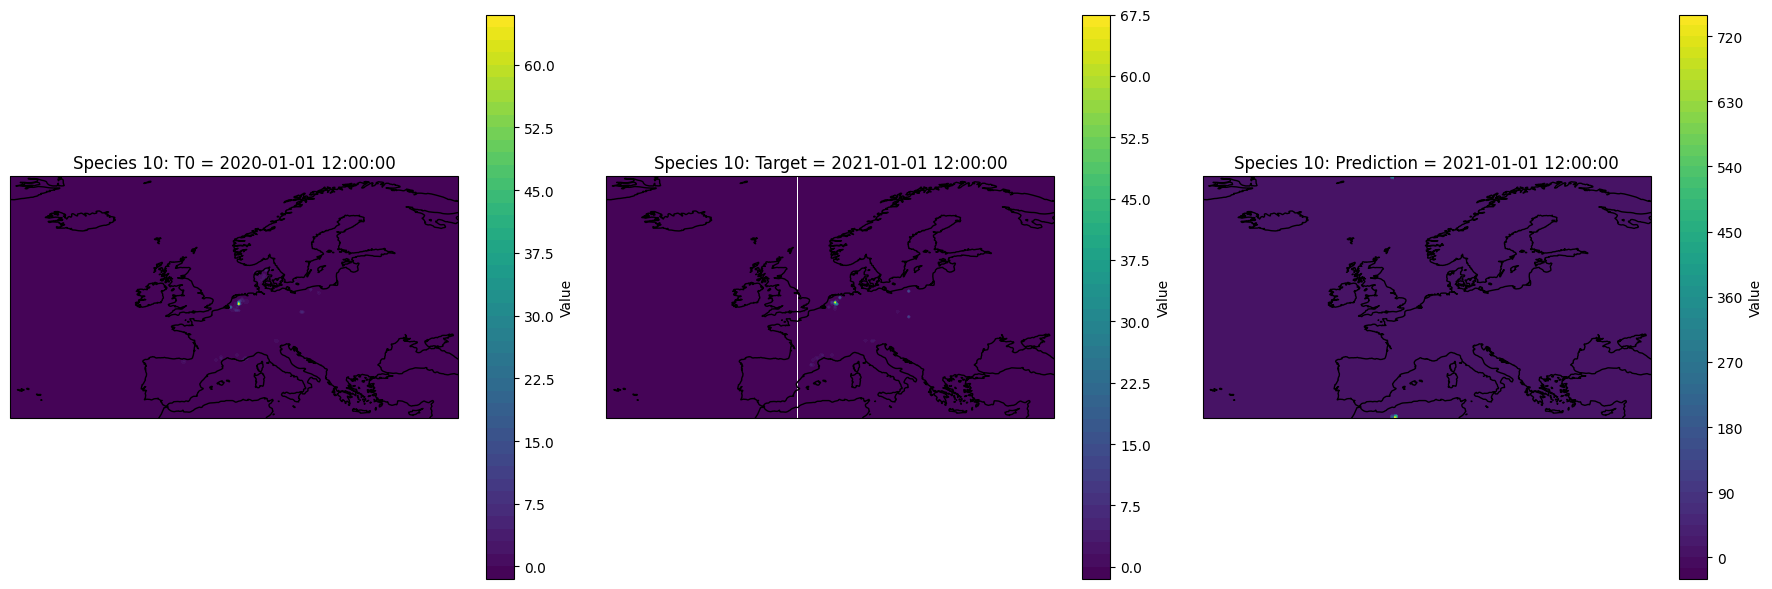

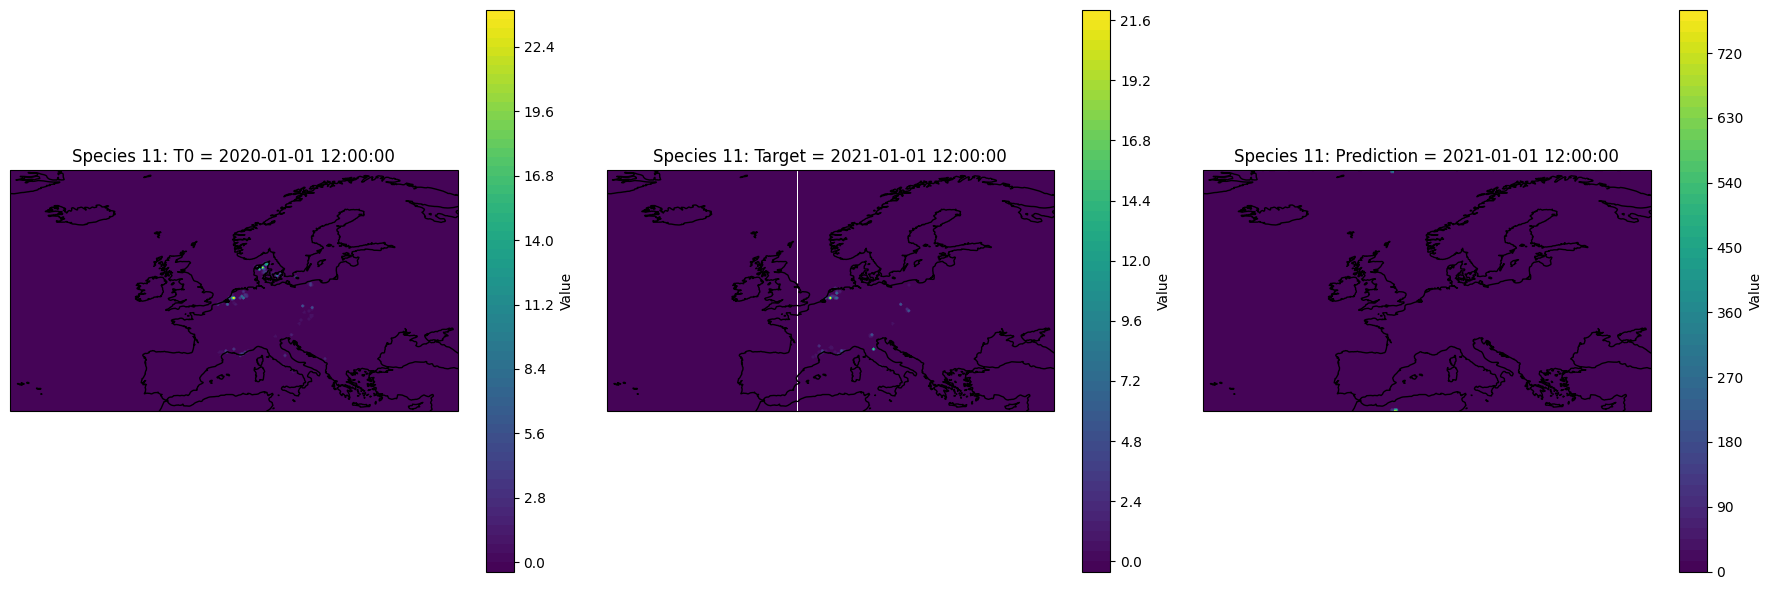

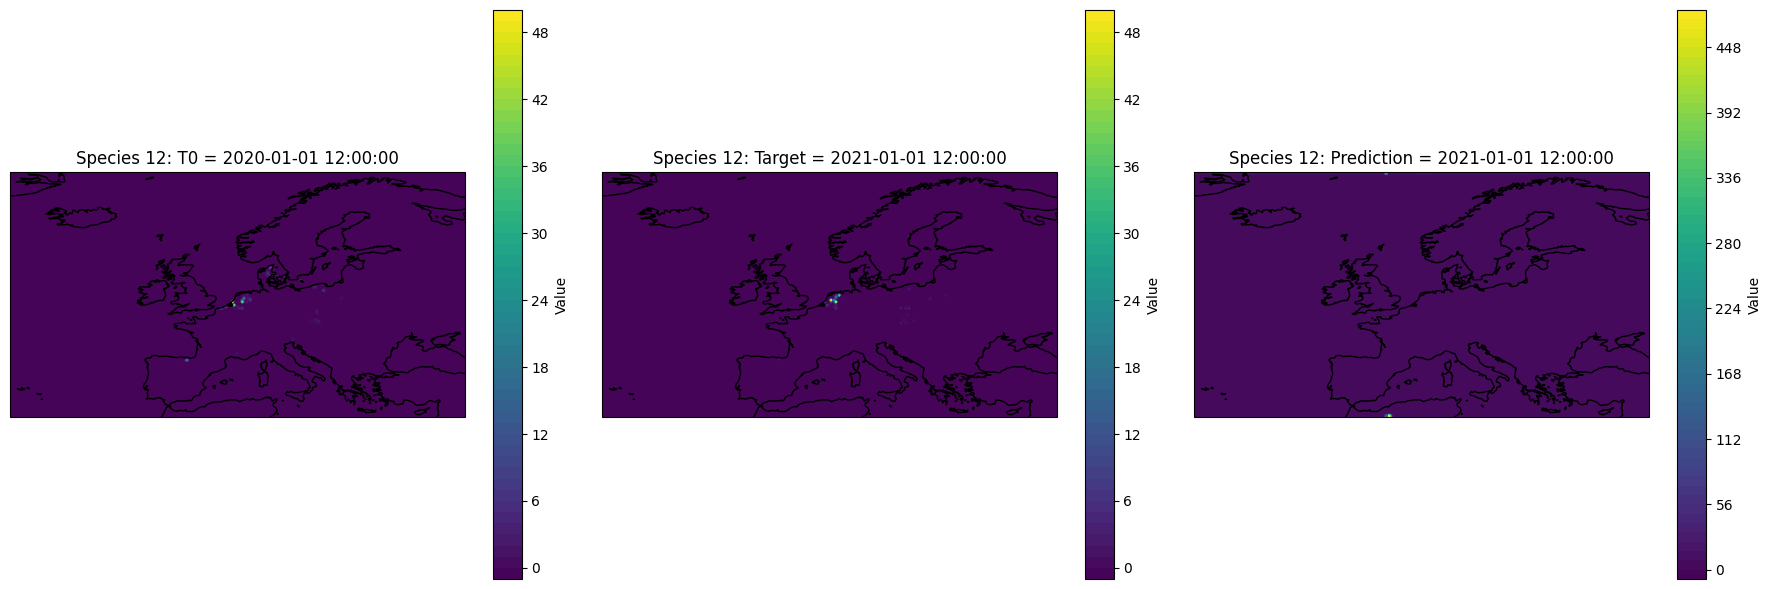

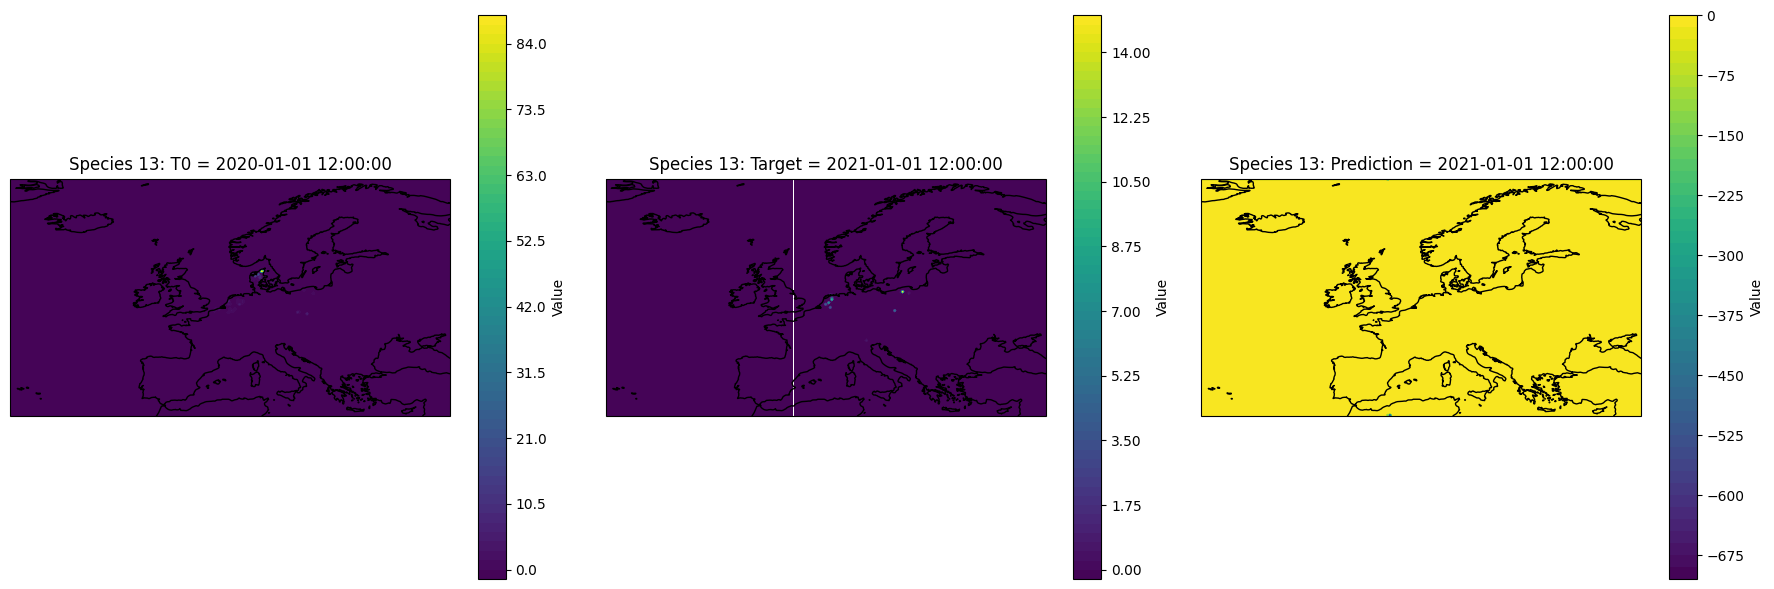

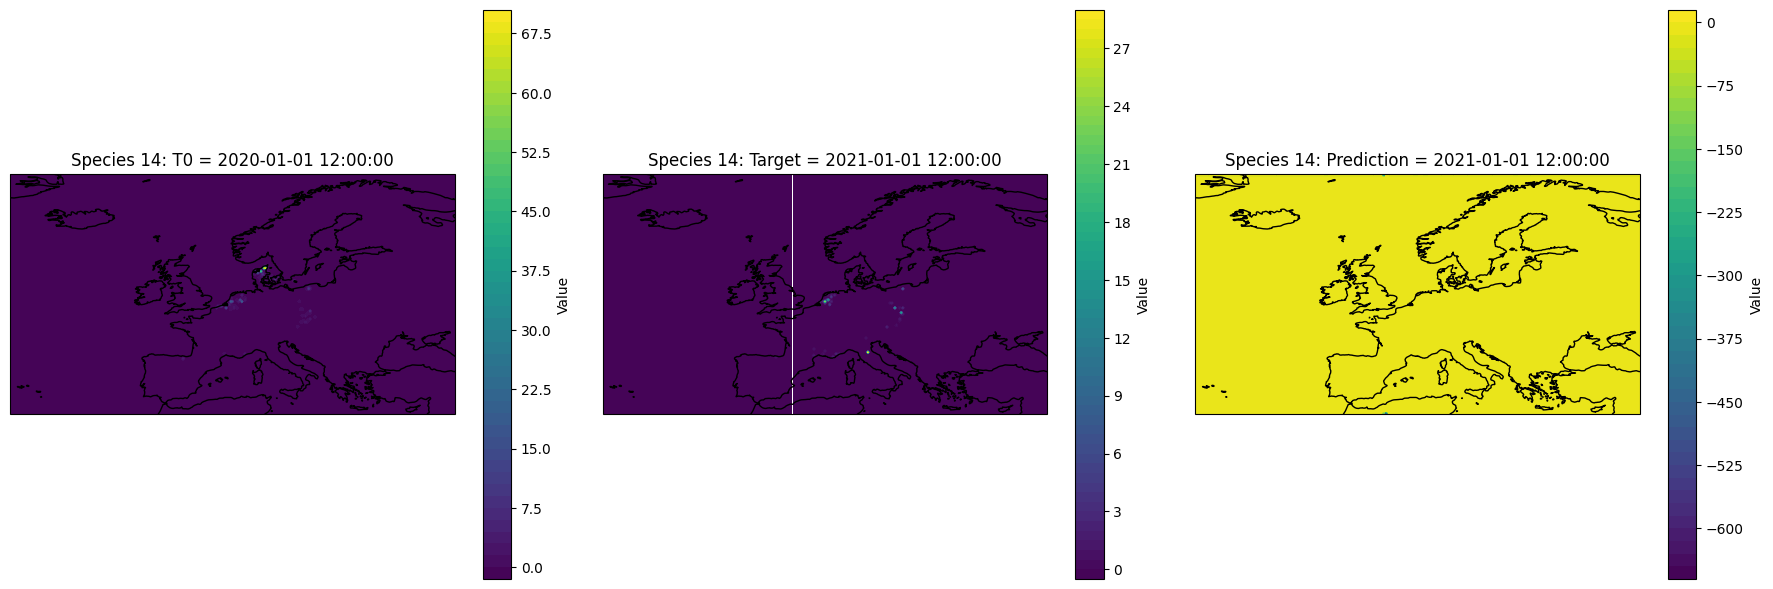

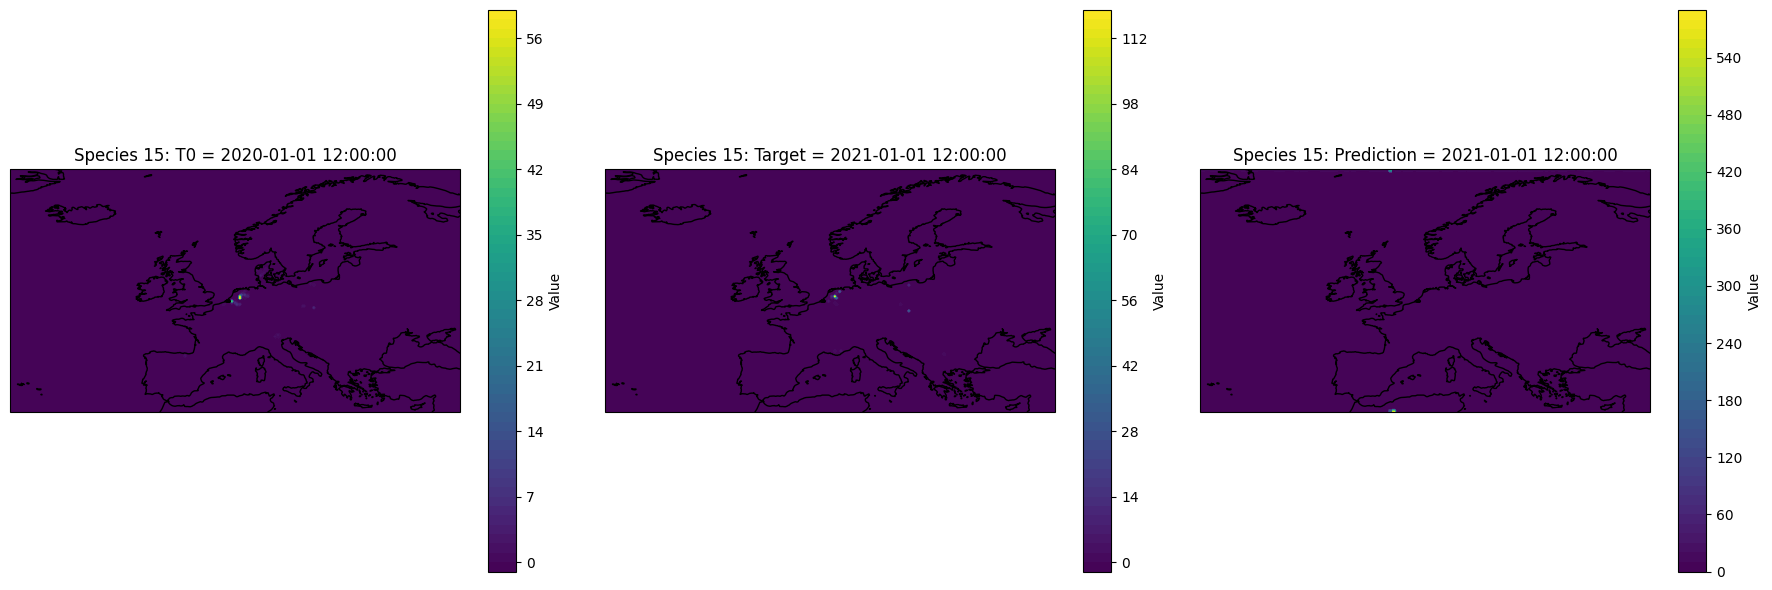

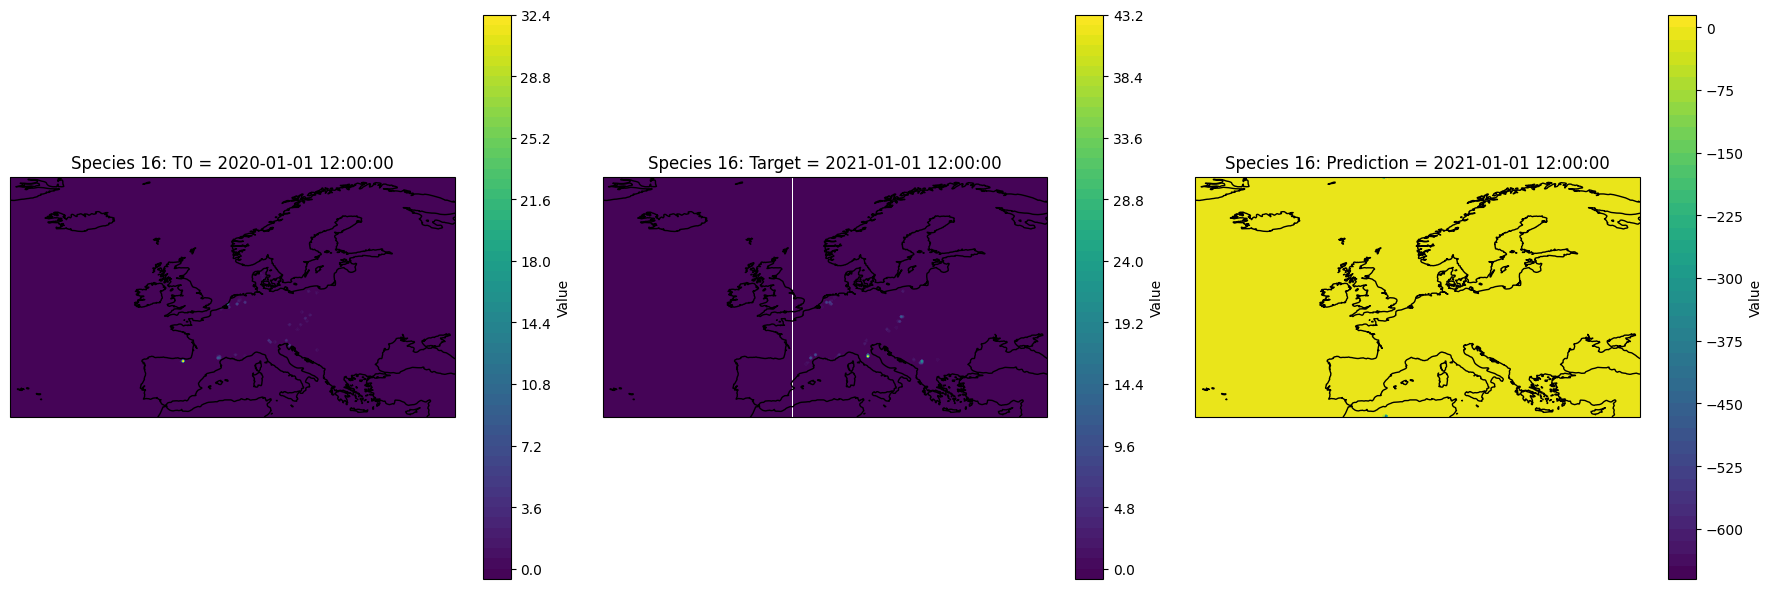

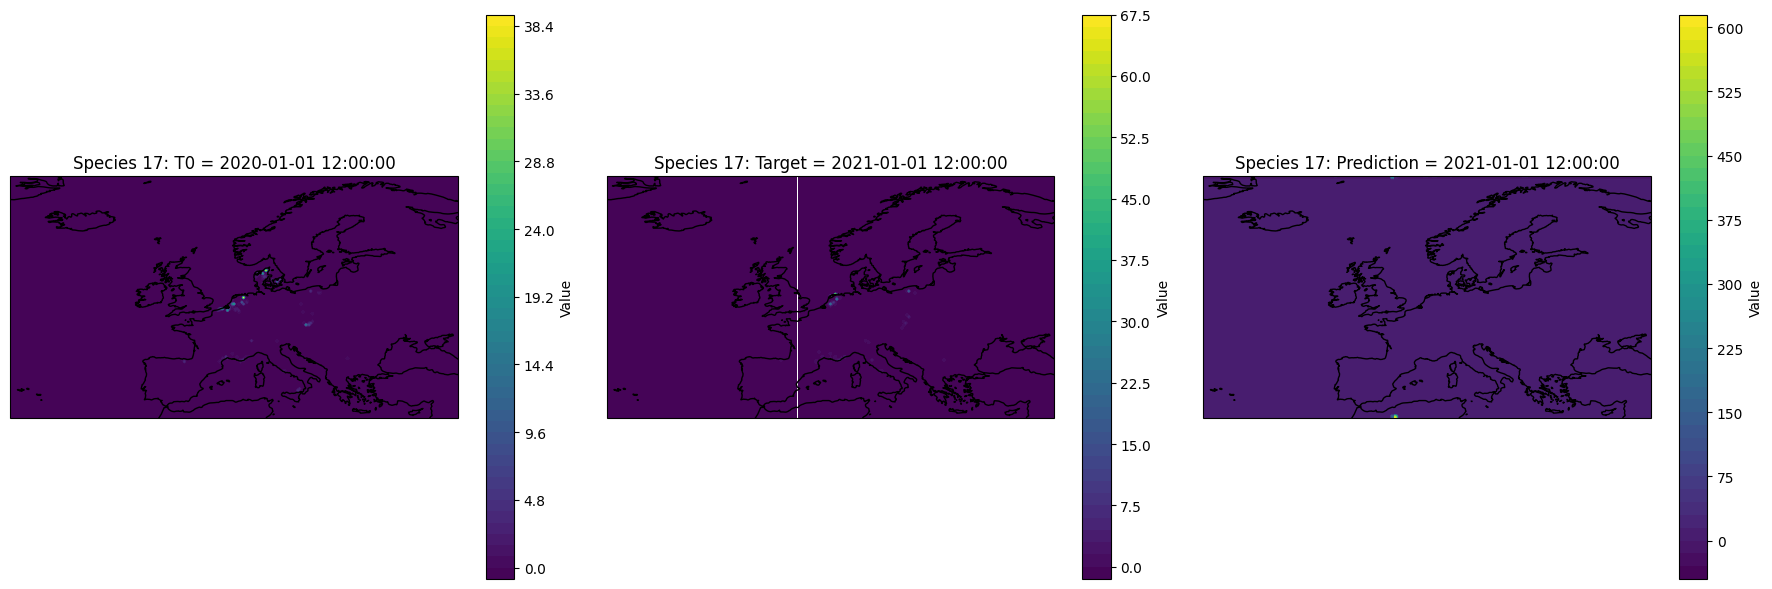

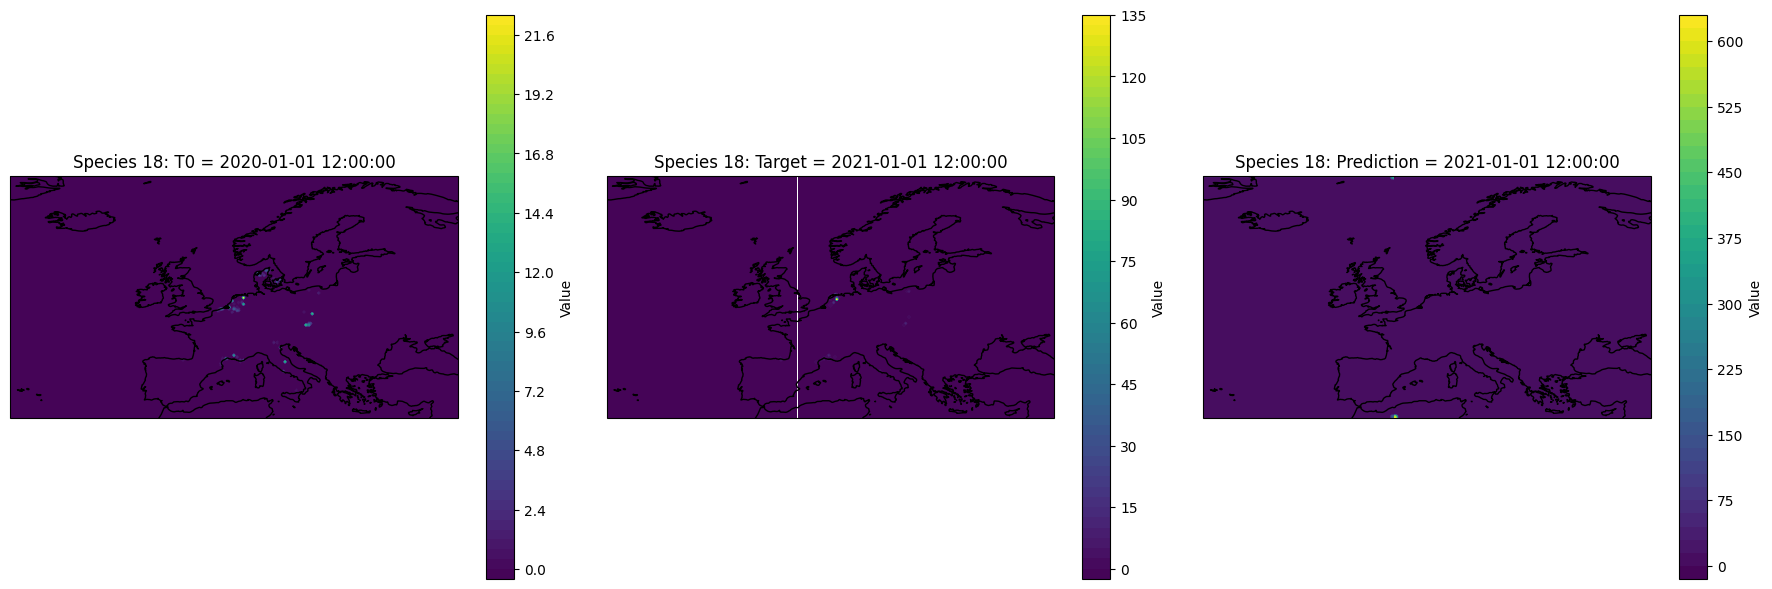

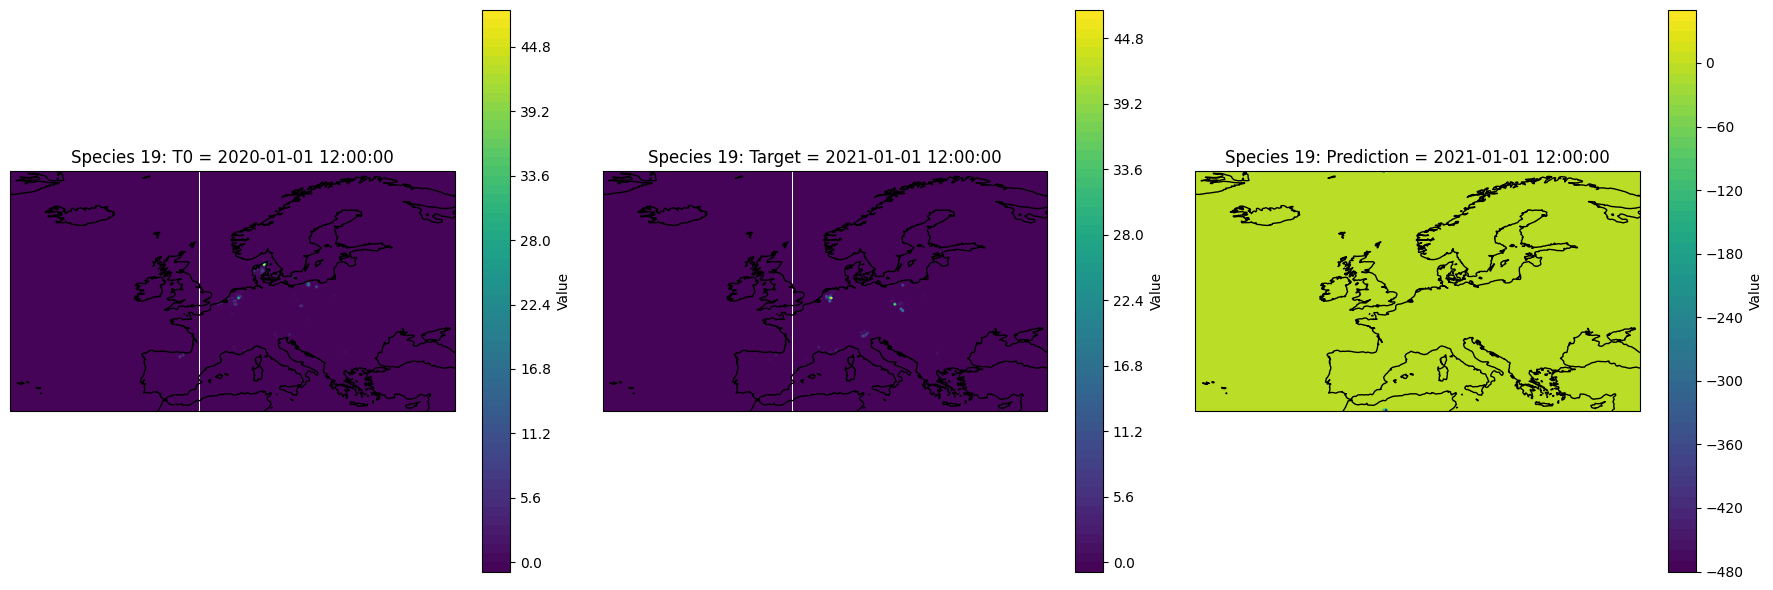

In [30]:
for sample in val_dataloader:
    batch = sample["batch"]# .to(device)
    batch["species_distribution"] = batch["species_distribution"].to(device)
    target = sample["target"]
    with torch.inference_mode():
        prediction = model.forward(batch)

    # Roll prediction & unnormalize
    prediction = roll_tensor_to_match_lon(prediction, batch["metadata"]["lon"])
    unnormalized_preds = val_dataset.scale_species_distribution(prediction.clone(), unnormalize=True)
    unnormalized_preds = roll_tensor_to_match_lon(unnormalized_preds, batch["metadata"]["lon"])
    plot_eval(
        batch=batch,
        prediction_species=unnormalized_preds,
        out_dir="plots_dir",
        save=False,
    )